In [60]:
%run PVModel_functions.ipynb

In [ ]:
%run PVsystem_filterfunction_jack.ipynb

In [180]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [62]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
#Valid sys table names: dbo.PVLT_Pan_LG_Panasonic_LG,dbo.PVLT_Can_Han_Canadian_Hanwha,
#                       dbo.PVLT_TrinaJinko_Jinko, dbo.PVLT_MissionSolar_MissionSolar

mod_name = 'Panasonic'
mettablename =  'dbo.SNLA_Met_DataOut'

In [70]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
systablename = module['table_name']
start = module['start']
end = module['end']

In [133]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [72]:
df.columns

Index(['RecNum_x', 'Global_Wm2_Avg', 'Direct_Wm2_Avg', 'Diffuse_Wm2_Avg',
       'Pressure_mBar_Avg', 'WS_ms_Mean', 'Wdir_Mean', 'Wdir_Std', 'WS_ms_Std',
       'WS_ms_3sec_Max', 'WD_deg_SMM', 'Temp_C_Avg', 'RH_pct_Avg',
       'Panel_Temp_C_Avg', 'Battery_V_Avg', 'ProcessTime_S_Max',
       'Global_mV_Avg', 'Rain_mm_Tot', 'Rain_mm_Daily', 'Temp_CMP22_C_Avg',
       'RecNum_y', 'BroadbandPOA_Avg', 'POACleanRC_E_Avg', 'GHI_Avg',
       'Albedo_Avg', 'AmbientTemp_Avg', 'PH1_V_Avg', 'PH2_V_Avg', 'PH3_V_Avg',
       'PH4_V_Avg', 'LM1_V_Avg', 'LM2_V_Avg', 'LM3_V_Avg', 'LM4_V_Avg',
       'PH1_I_Avg', 'PH2_I_Avg', 'PH3_I_Avg', 'PH4_I_Avg', 'LM1_I_Avg',
       'LM2_I_Avg', 'LM3_I_Avg', 'LM4_I_Avg', 'PH1_RTD_Avg', 'PH2_RTD_Avg',
       'PH3_RTD_Avg', 'PH4_RTD_Avg', 'LM1_RTD_Avg', 'LM2_RTD_Avg',
       'LM3_RTD_Avg', 'LM4_RTD_Avg', 'Wind_Speed_Avg', 'Wind_Direction_Avg',
       'Wind_Dir_std', 'Wind_Gust_Max'],
      dtype='object')

In [73]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
#merge this information into one solar & environmental data df called 'sedf'
sedf = pd.merge(edf,sdf,how='inner', left_index=True, right_index=True)

In [74]:
#Generate a results dataframe and add measured values
results = meas_val(df[module['str_1_v']],df[module['str_1_i']])
results = results.to_frame()

In [75]:
#read in SAM data from the spreadsheet containing all SAM results for entire time period of system
sam_data = pd.read_excel('SAM_results.xlsx', sheet_name = [mod_name])
sam_data = sam_data[mod_name]
sam_data.index = sam_data['Time']
del sam_data['Time']
sam_data.rename(columns = {mod_name : 'SAM'}, inplace = True)
results['SAM'] = sam_data['SAM']

In [76]:
#Calcualte SAPM results and add to df
sapm_par = sapm_param(sedf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.AmbientTemp_Avg, df.Wind_Speed_Avg, 
                   sedf['am_abs'], sedf['aoi'], module)
dc = sapm(sapm_par['eff_irr'], sapm_par['tcell'], module)
results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])

In [77]:
#Calculate PVWatts results and add to df
results['PVWatts'] = pvwatts(POA_eff = df['BroadbandPOA_Avg'], cell_temp = df[module['str_1_rtd']], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'], temp_ref=25.0 )

In [78]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4])
results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:613: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /


In [79]:
#Calculate Desoto results and add to df
ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4])
results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])

In [80]:
#Calculte PVSystem results and add to df
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4])
results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])

In [139]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

#Until the other function is complete, I have this setup just to get out all negative values, but it leads to problems at times
df.loc[df['BroadbandPOA_Avg']<0, 'BroadbandPOA_Avg'] = 0

In [164]:
#Calculate ADR results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
adr_eff = adr(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
adr_p = df['BroadbandPOA_Avg'] * adr_eff * module['Area'] 
results['ADR'] = adr_p.resample('H').mean()

In [166]:
#Calculate Heydenreich results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
hey_eff = heydenreich(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
hey_p = df['BroadbandPOA_Avg'] * hey_eff * module['Area']
results['Heydenreich'] = hey_p.resample('H').mean()

In [167]:
#Calculate MotherPV results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
mother_eff = motherpv(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
mother_p = df['BroadbandPOA_Avg'] * mother_eff * module['Area']
results['Mother'] = hey_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:333: RuntimeWarning: divide by zero encountered in log
  eta = ( 1 + a * (s - 1)    + b * log(s)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:334: RuntimeWarning: divide by zero encountered in log
  + c * (s - 1)**2 + d * log(s)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:333: RuntimeWarning: invalid value encountered in add
  eta = ( 1 + a * (s - 1)    + b * log(s)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:336: RuntimeWarning: divide by zero encountered in log
  gamma = gamma_ref * ( 1 + aa * (s - 1) + bb * log(s))


In [168]:
#Calculate PVGIS results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
pvgis_eff = pvgis(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
pvgis_p = df['BroadbandPOA_Avg'] * pvgis_eff * module['Area']
results['PVGIS'] = hey_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:400: RuntimeWarning: divide by zero encountered in log
  + k1 * log(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:401: RuntimeWarning: divide by zero encountered in log
  + k2 * log(g)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:403: RuntimeWarning: divide by zero encountered in log
  + k4 * log(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:404: RuntimeWarning: divide by zero encountered in log
  + k5 * log(g)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:399: RuntimeWarning: invalid value encountered in add
  eta = ( 1


In [177]:
#Calculate MPM5 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
mpm5_eff = mpm5(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
mpm5_p = df['BroadbandPOA_Avg'] * mpm5_eff * module['Area']
results['MPM5'] = mpm5_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:478: RuntimeWarning: divide by zero encountered in log10
  + c3 * np.log10(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:482: RuntimeWarning: invalid value encountered in true_divide
  + c6 / g


In [178]:
#Calculate MPM6 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
mpm6_eff = mpm6(df['BroadbandPOA_Avg'], df[module['str_1_rtd']], *popt)
mpm6_p = df['BroadbandPOA_Avg'] * mpm6_eff * module['Area']
results['MPM6'] = mpm6_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:482: RuntimeWarning: divide by zero encountered in true_divide
  + c6 / g


Text(0, 0.5, 'Power (W)')

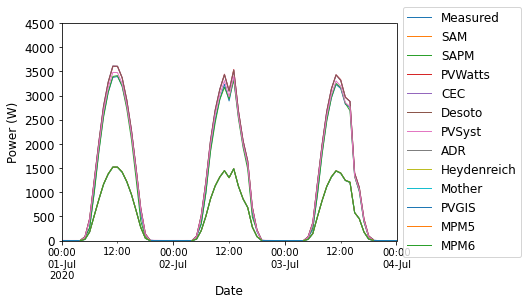

In [179]:
#Plot just for fun
results.rename(columns = { 0 : 'Measured'}, inplace = True)
results.plot()
plt.xlim('2020-07-01', '2020-07-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')